## Course: Data Analitycs
### Team: Sim Lyheng, Tan Chesthareah

---

RFM Workflow

In [2]:
# Import the library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

### Understading the data

In [3]:
df = pd.read_csv('rfm_data_orders.rda (2).csv')

df.head()

,Unnamed: 0,customer_id,order_date,revenue,first_name,last_name,email
0,0,Brion Stark,2004-12-20,32,Brion,Stark,brion_stark@rfmail.com
1,1,Ethyl Botsford,2005-05-02,36,Ethyl,Botsford,ethyl_botsford@rfmail.com
2,2,Hosteen Jacobi,2004-03-06,116,Hosteen,Jacobi,hosteen_jacobi@rfmail.com
3,3,Edw Frami,2006-03-15,99,Edw,Frami,edw_frami@rfmail.com
4,4,Josef Lemke,2006-08-14,76,Josef,Lemke,josef_lemke@rfmail.com


### Clean and Prepare the Data

In [4]:
# Drop unnecessary columns
df = df.drop(columns=['first_name', 'last_name', 'email'])


In [5]:
# convert the date to Date/DateTime format
df['order_date'] = pd.to_datetime(df['order_date'])

# onvert the revenue to numeric
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

df.head()

,Unnamed: 0,customer_id,order_date,revenue
0,0,Brion Stark,2004-12-20,32
1,1,Ethyl Botsford,2005-05-02,36
2,2,Hosteen Jacobi,2004-03-06,116
3,3,Edw Frami,2006-03-15,99
4,4,Josef Lemke,2006-08-14,76


In [6]:
df = df.sort_values(by=['customer_id', 'order_date'])
df

,Unnamed: 0,customer_id,order_date,revenue
3760,3760,Abbey O'Reilly,2005-07-16,47
4418,4418,Abbey O'Reilly,2005-09-04,152
4180,4180,Abbey O'Reilly,2005-11-03,41
313,313,Abbey O'Reilly,2005-12-24,145
1691,1691,Abbey O'Reilly,2006-01-06,67
...,...,...,...,...
999,999,Zillah Koch,2005-07-01,41
2817,2817,Zola Nolan,2006-04-03,171
1774,1774,Zola Nolan,2006-04-09,54
3677,3677,Zola Nolan,2006-04-25,52


### Compute RFM metrics

In [7]:
analysis_date = df["order_date"].max()

rfm = df.groupby("customer_id").agg(
    recency=('order_date', lambda x: (analysis_date - x.max()).days),  # Days since last purchase
    frequency=('order_date', 'count'),  # Unique order dates
    monetary=('revenue', 'sum')  # Total spent
).reset_index()

rfm

,customer_id,recency,frequency,monetary
0,Abbey O'Reilly,204,6,472
1,Add Senger,139,3,340
2,Aden Lesch,193,4,405
3,Aden Murphy,97,7,596
4,Admiral Senger,131,5,448
...,...,...,...,...
990,Zechariah Gislason,206,9,1196
991,Zenas Pacocha,404,4,442
992,Zeno Lakin,523,1,38
993,Zillah Koch,547,4,516


### Monetary Score

In [8]:
monetary_quantiles = rfm['monetary'].quantile([0.2, 0.4, 0.6, 0.8, 1.0])

# Define bins based on quantile thresholds
bins = [0, monetary_quantiles[0.2], monetary_quantiles[0.4], monetary_quantiles[0.6], monetary_quantiles[0.8], rfm['monetary'].max()]
labels = [1, 2, 3, 4, 5]

# Assign monetary scores
rfm['monetary_score'] = pd.cut(rfm['monetary'], bins=bins, labels=labels, include_lowest=True)


In [9]:
rfm["Interval"] = pd.cut(rfm["monetary"], bins=bins, labels=[
    f"<= {monetary_quantiles[0.2]:.1f}",
    f"> {monetary_quantiles[0.2]:.1f} & <= {monetary_quantiles[0.4]:.1f}",
    f"> {monetary_quantiles[0.4]:.1f} & <= {monetary_quantiles[0.6]:.1f}",
    f"> {monetary_quantiles[0.6]:.1f} & <= {monetary_quantiles[0.8]:.1f}",
    f"> {monetary_quantiles[0.8]:.1f}"
], include_lowest=True)

rfm_monetary_score = rfm[['customer_id', 'monetary', 'Interval', 'monetary_score']]

rfm_monetary_score


,customer_id,monetary,Interval,monetary_score
0,Abbey O'Reilly,472,> 381.0 & <= 505.4,3
1,Add Senger,340,> 254.8 & <= 381.0,2
2,Aden Lesch,405,> 381.0 & <= 505.4,3
3,Aden Murphy,596,> 505.4 & <= 665.0,4
4,Admiral Senger,448,> 381.0 & <= 505.4,3
...,...,...,...,...
990,Zechariah Gislason,1196,> 665.0,5
991,Zenas Pacocha,442,> 381.0 & <= 505.4,3
992,Zeno Lakin,38,<= 254.8,1
993,Zillah Koch,516,> 505.4 & <= 665.0,4


### Frequency Score

In [10]:
frequency_quantiles = rfm['frequency'].quantile([0.2, 0.4, 0.6, 0.8, 1.0])

# Define bins based on quantile thresholds
bins = [0, frequency_quantiles[0.2], frequency_quantiles[0.4], frequency_quantiles[0.6], frequency_quantiles[0.8], rfm['frequency'].max()]
labels = [1, 2, 3, 4, 5]

# Assign frequency scores
rfm['frequency_score'] = pd.cut(rfm['frequency'], bins=bins, labels=labels, include_lowest=True)



In [11]:

# Create readable intervals
rfm["Interval"] = pd.cut(rfm["frequency"], bins=bins, labels=[
    f"<= {frequency_quantiles[0.2]:.0f}",
    f"> {frequency_quantiles[0.2]:.0f} & <= {frequency_quantiles[0.4]:.0f}",
    f"> {frequency_quantiles[0.4]:.0f} & <= {frequency_quantiles[0.6]:.0f}",
    f"> {frequency_quantiles[0.6]:.0f} & <= {frequency_quantiles[0.8]:.0f}",
    f"> {frequency_quantiles[0.8]:.0f}"
], include_lowest=True)

rfm_frequency_score = rfm[['customer_id', 'frequency', 'Interval', 'frequency_score']]
rfm_frequency_score

,customer_id,frequency,Interval,frequency_score
0,Abbey O'Reilly,6,> 5 & <= 7,4
1,Add Senger,3,<= 3,1
2,Aden Lesch,4,> 3 & <= 4,2
3,Aden Murphy,7,> 5 & <= 7,4
4,Admiral Senger,5,> 4 & <= 5,3
...,...,...,...,...
990,Zechariah Gislason,9,> 7,5
991,Zenas Pacocha,4,> 3 & <= 4,2
992,Zeno Lakin,1,<= 3,1
993,Zillah Koch,4,> 3 & <= 4,2


### Recency Score

In [12]:
Recency_quantiles = rfm['recency'].quantile([0.2, 0.4, 0.6, 0.8, 1.0])

# Define bins based on quantile thresholds (recency is inverted: lower recency is better)
bins = [0, Recency_quantiles[0.2], Recency_quantiles[0.4], Recency_quantiles[0.6], Recency_quantiles[0.8], rfm['recency'].max()]
labels = [5, 4, 3, 2, 1]  # Lower recency (more recent) gets a higher score


In [13]:

# Assign recency scores
rfm['recency_score'] = pd.cut(rfm['recency'], bins=bins, labels=labels, include_lowest=True)

# Create readable intervals
rfm["Interval"] = pd.cut(rfm["recency"], bins=bins, labels=[
    f"<= {Recency_quantiles[0.2]:.1f}",
    f"> {Recency_quantiles[0.2]:.1f} & <= {Recency_quantiles[0.4]:.1f}",
    f"> {Recency_quantiles[0.4]:.1f} & <= {Recency_quantiles[0.6]:.1f}",
    f"> {Recency_quantiles[0.6]:.1f} & <= {Recency_quantiles[0.8]:.1f}",
    f"> {Recency_quantiles[0.8]:.1f}"
], include_lowest=True)

rfm_recency_score = rfm[['customer_id', 'recency', 'Interval', 'recency_score']]
rfm_recency_score


,customer_id,recency,Interval,recency_score
0,Abbey O'Reilly,204,> 179.0 & <= 295.4,3
1,Add Senger,139,> 113.0 & <= 179.0,4
2,Aden Lesch,193,> 179.0 & <= 295.4,3
3,Aden Murphy,97,<= 113.0,5
4,Admiral Senger,131,> 113.0 & <= 179.0,4
...,...,...,...,...
990,Zechariah Gislason,206,> 179.0 & <= 295.4,3
991,Zenas Pacocha,404,> 295.4 & <= 480.0,2
992,Zeno Lakin,523,> 480.0,1
993,Zillah Koch,547,> 480.0,1


### Merge score

In [14]:
marge_rfm = rfm_recency_score[['customer_id', 'recency', 'recency_score']].merge(
    rfm_frequency_score[['customer_id', 'frequency', 'frequency_score']], on='customer_id'
).merge(
    rfm_monetary_score[['customer_id', 'monetary', 'monetary_score']], on='customer_id'
)

marge_rfm.columns = ['Customer', 'Recency (Days)', 'R', 'Frequency', 'F', 'Monetary ($)', 'M']
marge_rfm


,Customer,Recency (Days),R,Frequency,F,Monetary ($),M
0,Abbey O'Reilly,204,3,6,4,472,3
1,Add Senger,139,4,3,1,340,2
2,Aden Lesch,193,3,4,2,405,3
3,Aden Murphy,97,5,7,4,596,4
4,Admiral Senger,131,4,5,3,448,3
...,...,...,...,...,...,...,...
990,Zechariah Gislason,206,3,9,5,1196,5
991,Zenas Pacocha,404,2,4,2,442,3
992,Zeno Lakin,523,1,1,1,38,1
993,Zillah Koch,547,1,4,2,516,4


### RFM Score

In [15]:
marge_rfm['R'] = marge_rfm['R'].astype(int)
marge_rfm['F'] = marge_rfm['F'].astype(int)
marge_rfm['M'] = marge_rfm['M'].astype(int)

marge_rfm['RFM Score'] = marge_rfm['R'] * 100 + marge_rfm['F'] * 10 + marge_rfm['M']

marge_rfm.columns = ['Customer', 'Recency (Days)', 'R', 'Frequency', 'F', 'Monetary ($)', 'M','RFM Score']
marge_rfm

,Customer,Recency (Days),R,Frequency,F,Monetary ($),M,RFM Score
0,Abbey O'Reilly,204,3,6,4,472,3,343
1,Add Senger,139,4,3,1,340,2,412
2,Aden Lesch,193,3,4,2,405,3,323
3,Aden Murphy,97,5,7,4,596,4,544
4,Admiral Senger,131,4,5,3,448,3,433
...,...,...,...,...,...,...,...,...
990,Zechariah Gislason,206,3,9,5,1196,5,355
991,Zenas Pacocha,404,2,4,2,442,3,223
992,Zeno Lakin,523,1,1,1,38,1,111
993,Zillah Koch,547,1,4,2,516,4,124


### Segments

In [16]:
# Define a function to categorize customers into segments
def assign_segment(row):
    r, f, m = row['R'], row['F'], row['M']
    
    if r >= 4 and f >= 4 and m >= 4:
        return "Champion"
    elif 2 <= r <= 4 and 3 <= f <= 4 and m >= 4:
        return "Loyal Customer"
    elif 3 <= r <= 5 and 1 <= f <= 3 and 1 <= m <= 3:
        return "Potential Loyalist"
    elif 4 <= r <= 5 and f < 2 and m < 2:
        return "New Customer"
    elif 3 <= r <= 4 and f < 2 and m < 2:
        return "Promising"
    elif 3 <= r <= 4 and 3 <= f <= 4 and 3 <= m <= 4:
        return "Need Attention"
    elif 2 <= r < 3 and f < 3 and m < 3:
        return "About to Sleep"
    elif r < 3 and 2 <= f <= 5 and 2 <= m <= 5:
        return "At Risk"
    elif r < 2 and 4 <= f <= 5 and 4 <= m <= 5:
        return "Can't Lose Them"
    elif 2 <= r <= 3 and 2 <= f <= 3 and 2 <= m <= 3:
        return "Hibernating"
    elif r < 2 and f < 2 and m < 2:
        return "Lost"
    else:
        return "Others"

marge_rfm['Segment'] = marge_rfm.apply(assign_segment, axis=1)

marge_rfm

,Customer,Recency (Days),R,Frequency,F,Monetary ($),M,RFM Score,Segment
0,Abbey O'Reilly,204,3,6,4,472,3,343,Need Attention
1,Add Senger,139,4,3,1,340,2,412,Potential Loyalist
2,Aden Lesch,193,3,4,2,405,3,323,Potential Loyalist
3,Aden Murphy,97,5,7,4,596,4,544,Champion
4,Admiral Senger,131,4,5,3,448,3,433,Potential Loyalist
...,...,...,...,...,...,...,...,...,...
990,Zechariah Gislason,206,3,9,5,1196,5,355,Others
991,Zenas Pacocha,404,2,4,2,442,3,223,At Risk
992,Zeno Lakin,523,1,1,1,38,1,111,Lost
993,Zillah Koch,547,1,4,2,516,4,124,At Risk


In [17]:
# segment_metrics = marge_rfm.groupby('Segment').agg(
#     Median_Recency=('Recency', 'median'),
#     Median_Frequency=('Frequency', 'median'),
#     Median_Monetary=('Monetary', 'median')
# ).reset_index()


### Segment Size

In [18]:
# segment_counts = marge_rfm['Segment'].value_counts().reset_index()
segment_counts = marge_rfm['Segment'].value_counts()
 
# Rename columns for clarity
segment_counts.columns = ['Segment', 'Customer Count']

segment_counts

Segment
Potential Loyalist    277
Champion              159
At Risk               148
Others                128
Loyal Customer        126
Lost                   75
About to Sleep         65
Need Attention         17
Name: count, dtype: int64

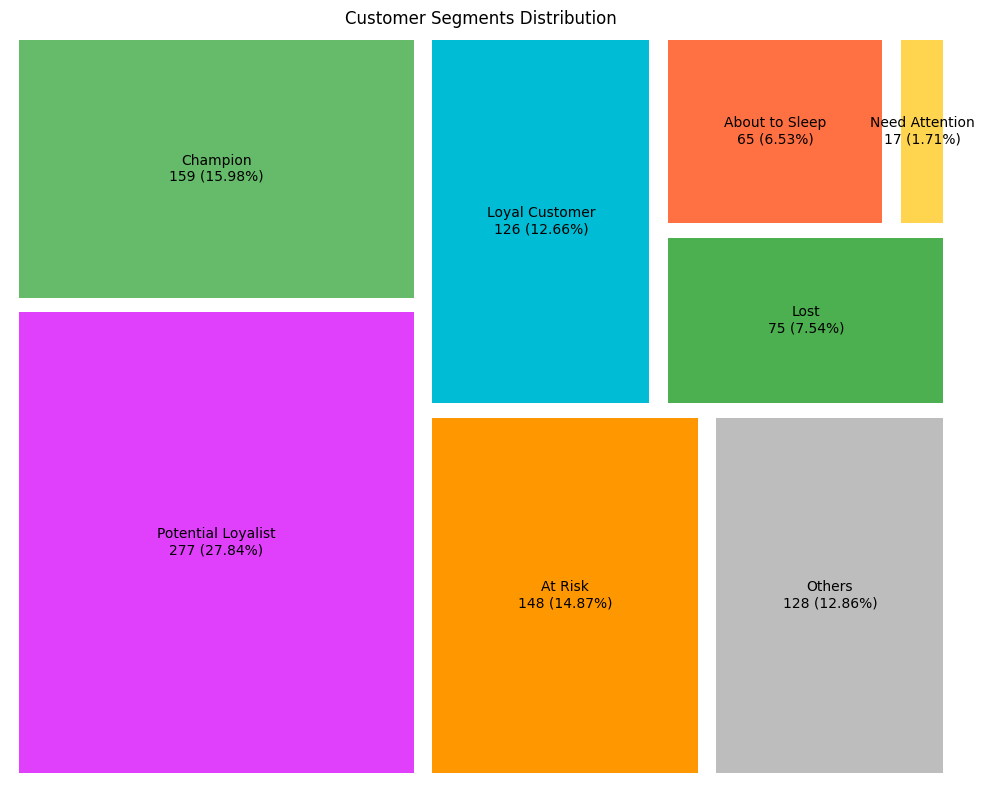

In [19]:
# segment_counts = marge_rfm['Segment'].value_counts()
total_customers = len(marge_rfm)
segment_percentages = segment_counts / total_customers * 100

# Create a dataframe for squarify
segments_df = pd.DataFrame({
    'Segment': segment_counts.index,
    'Count': segment_counts.values,
    'Percentage': segment_percentages.values
})

# Sort by count for better visualization
segments_df = segments_df.sort_values('Count', ascending=False)

# Create labels with count and percentage
segments_df['Label'] = segments_df.apply(
    lambda x: f"{x['Segment']}\n{int(x['Count'])} ({x['Percentage']:.2f}%)", axis=1)

# Define colors for each segment (matching your previous code's colors)
# Update your colors dictionary to match EXACTLY the segment names in your data
colors = {
    'Loyal Customer': '#00BCD4',       # Cyan
    'Potential Loyalist': '#E040FB',   # Purple
    'Lost': '#4CAF50',                 # Green
    'About to Sleep': '#FF7043',       # Coral
    'Champion': '#66BB6A',             # Light Green (changed from 'Champions')
    'At Risk': '#FF9800',              # Orange
    'Need Attention': '#FFD54F',       # Amber
    'Others': '#BDBDBD'                # Gray
}

# Create color list with debug output to verify matches
segment_colors = []
for segment in segments_df['Segment']:
    color = colors.get(segment, '#BDBDBD')
    # Optional: Add this line to debug which segments aren't matching
    # print(f"Segment: '{segment}', Color: {color}")
    segment_colors.append(color)
    
# Create the treemap
plt.figure(figsize=(10, 8))
squarify.plot(sizes=segments_df['Count'], 
              label=segments_df['Label'],
              color=segment_colors,
              alpha=1.0,
              pad=True)

plt.axis('off')
plt.title('Customer Segments Distribution')
plt.tight_layout()
plt.show()

### Median Recency

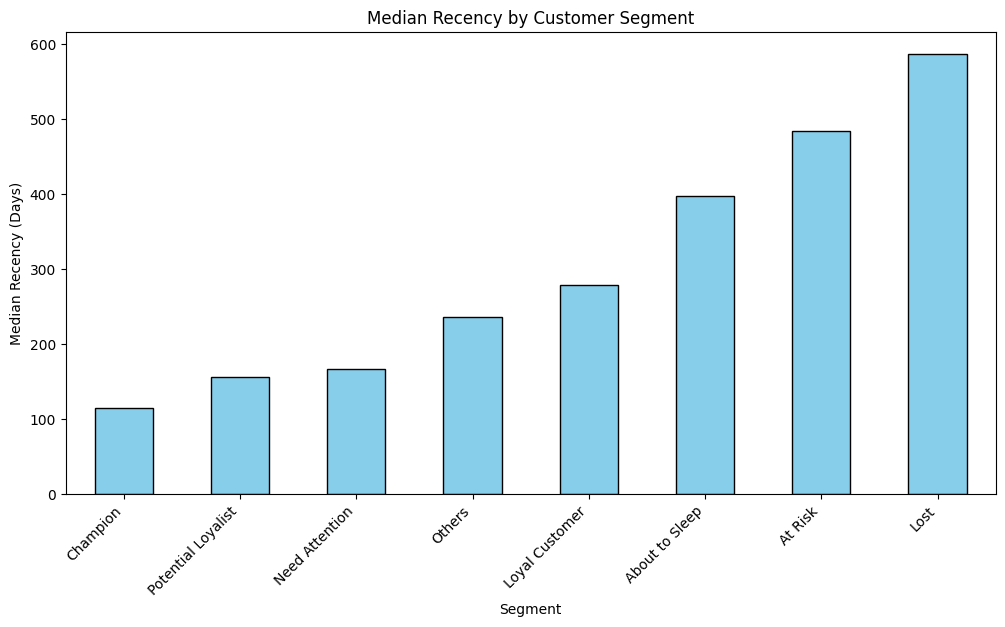

In [20]:
# Compute median recency for each segment
median_recency = marge_rfm.groupby('Segment')['Recency (Days)'].median().sort_values()

# Plot median recency for each segment
plt.figure(figsize=(12, 6))
median_recency.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot

plt.xlabel("Segment")
plt.ylabel("Median Recency (Days)")
plt.title("Median Recency by Customer Segment")
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


### Median Frequency

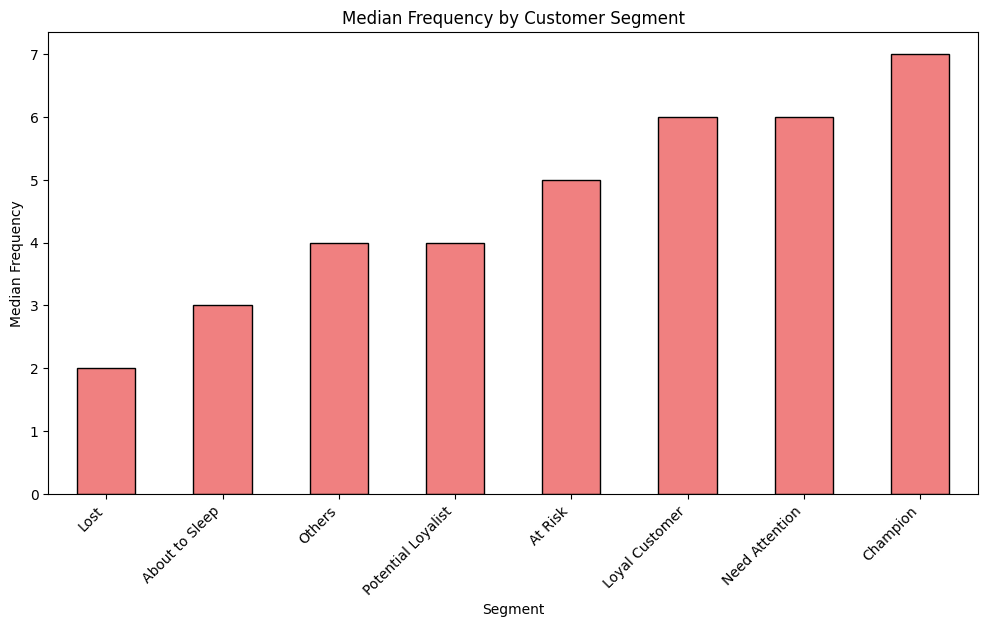

In [21]:
# Compute median frequency for each segment
median_frequency = marge_rfm.groupby('Segment')['Frequency'].median().sort_values()

# Plot median frequency for each segment
plt.figure(figsize=(12, 6))
median_frequency.plot(kind='bar', color='lightcoral', edgecolor='black')

# Customize the plot
plt.xlabel("Segment")
plt.ylabel("Median Frequency")
plt.title("Median Frequency by Customer Segment")
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


### Median Monetary Value

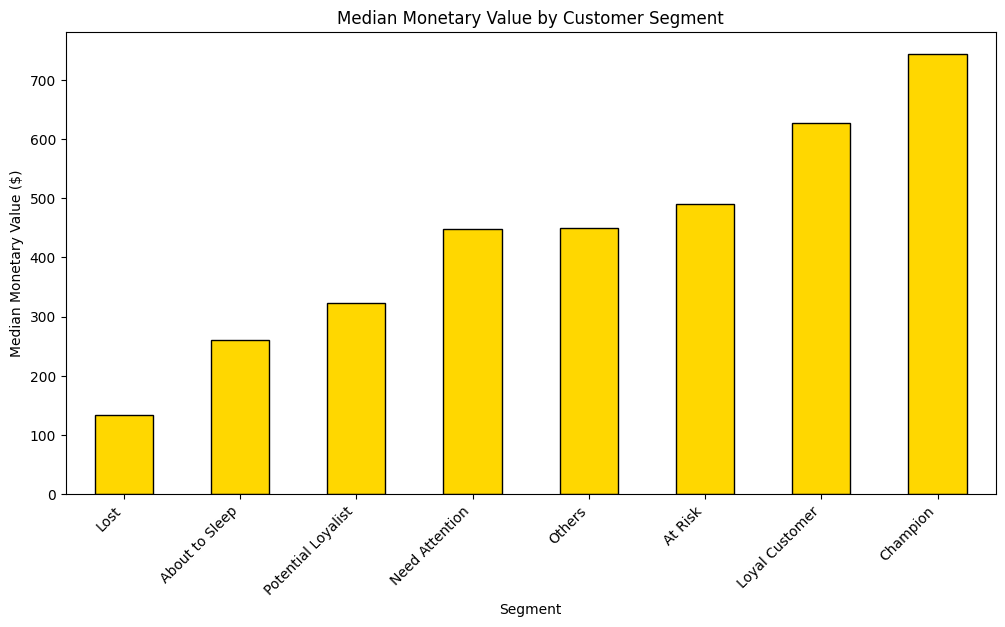

In [22]:
median_monetary = marge_rfm.groupby('Segment')['Monetary ($)'].median().sort_values()

# Plot median monetary value for each segment
plt.figure(figsize=(12, 6))
median_monetary.plot(kind='bar', color='gold', edgecolor='black')

# Customize the plot
plt.xlabel("Segment")
plt.ylabel("Median Monetary Value ($)")
plt.title("Median Monetary Value by Customer Segment")
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

### Heat Map

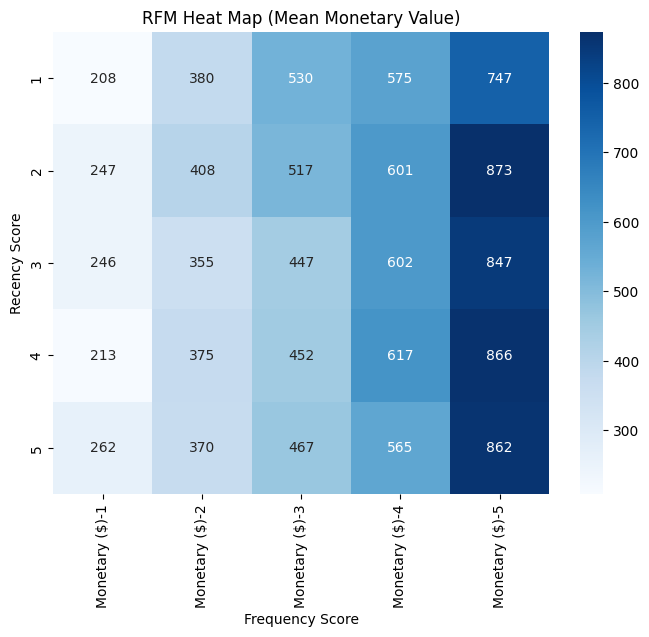

In [23]:
rfm_heatmap = marge_rfm.groupby(['R', 'F']).agg({'Monetary ($)': 'mean'}).unstack()
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_heatmap, cmap='Blues', annot=True, fmt=".0f")
plt.xlabel("Frequency Score")
plt.ylabel("Recency Score")
plt.title("RFM Heat Map (Mean Monetary Value)")
plt.show()


### Bar Chart

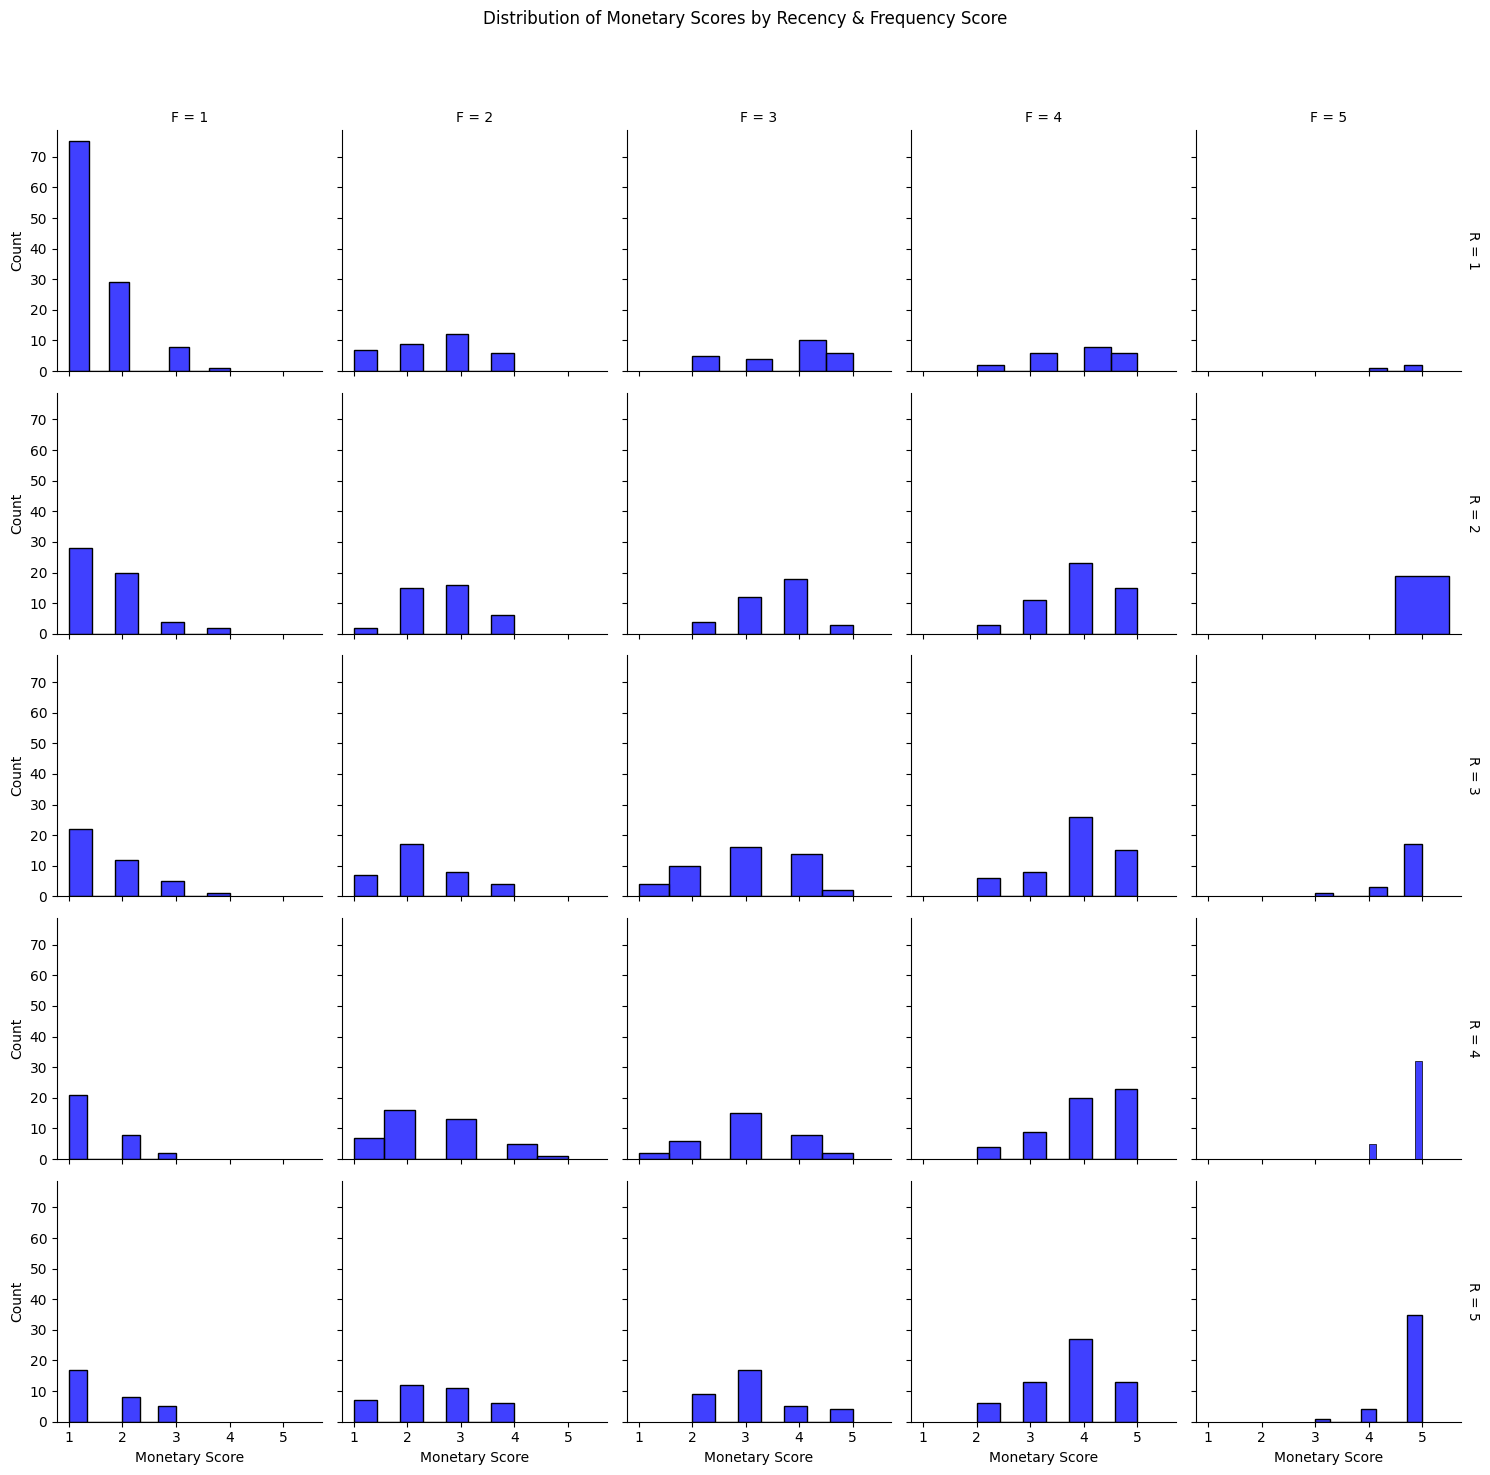

In [24]:
g = sns.FacetGrid(marge_rfm, row='R', col='F', margin_titles=True)
g.map_dataframe(sns.histplot, x='M', color='blue')  # Changed 'rfm_monetary_score' to 'M'
g.set_axis_labels("Monetary Score", "Count")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Monetary Scores by Recency & Frequency Score")
plt.show()

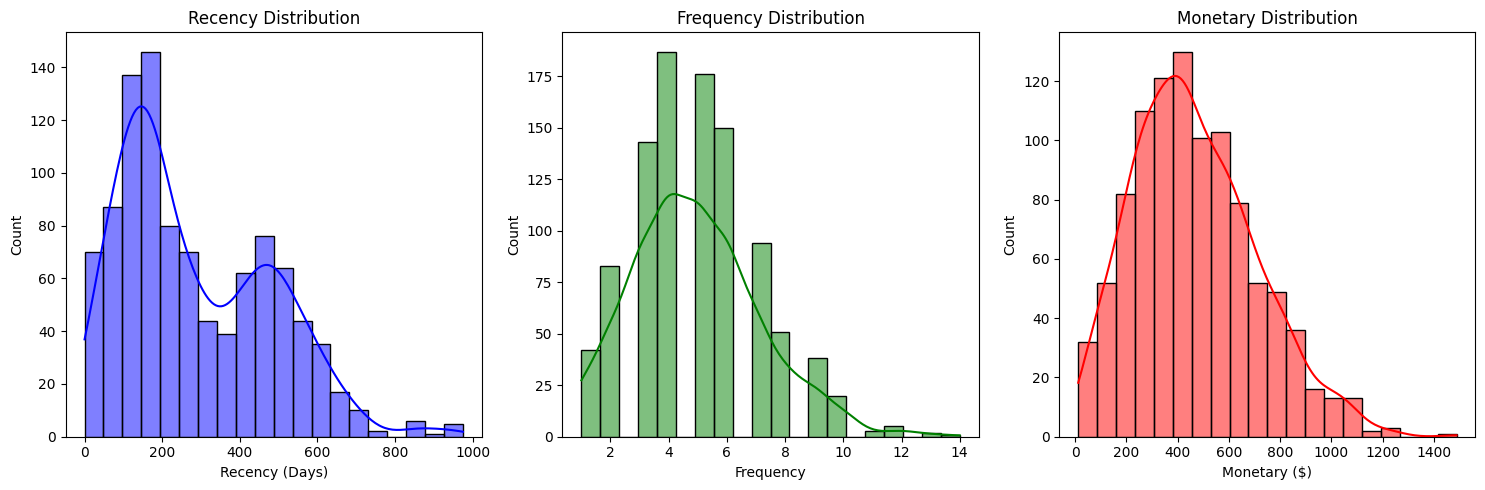

In [25]:
plt.figure(figsize=(15, 5))

# Recency Histogram
plt.subplot(1, 3, 1)
sns.histplot(marge_rfm["Recency (Days)"], bins=20, kde=True, color="blue")
plt.xlabel("Recency (Days)")
plt.title("Recency Distribution")

# Frequency Histogram
plt.subplot(1, 3, 2)
sns.histplot(marge_rfm["Frequency"], bins=20, kde=True, color="green")
plt.xlabel("Frequency")
plt.title("Frequency Distribution")

# Monetary Histogram
plt.subplot(1, 3, 3)
sns.histplot(marge_rfm["Monetary ($)"], bins=20, kde=True, color="red")
plt.xlabel("Monetary ($)")
plt.title("Monetary Distribution")

# Show the plots
plt.tight_layout()
plt.show()

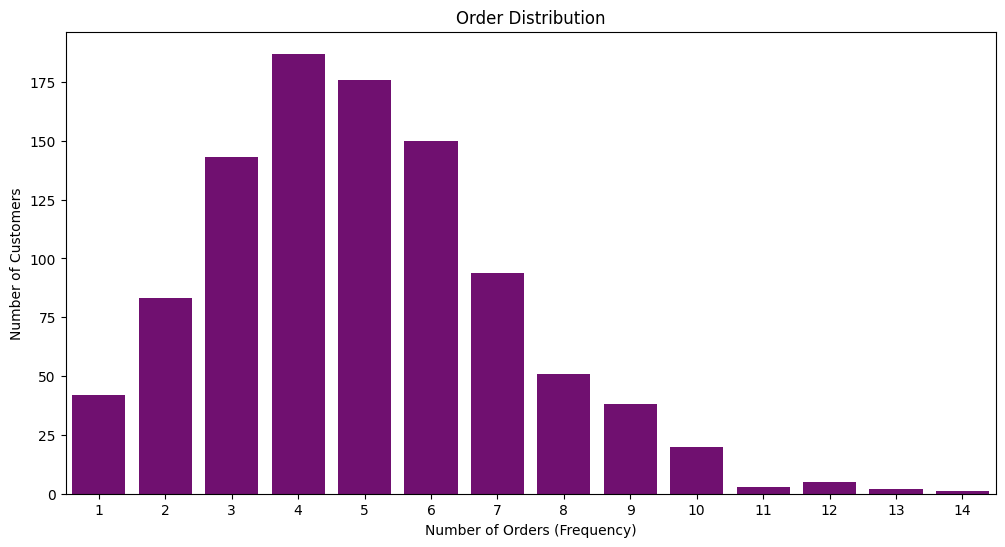

In [26]:
order_counts = marge_rfm["Frequency"].value_counts().sort_index()

# Plot the order distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=order_counts.index, y=order_counts.values, color="purple")

# Customize the plot
plt.xlabel("Number of Orders (Frequency)")
plt.ylabel("Number of Customers")
plt.title("Order Distribution")

# Show the plot
plt.show()

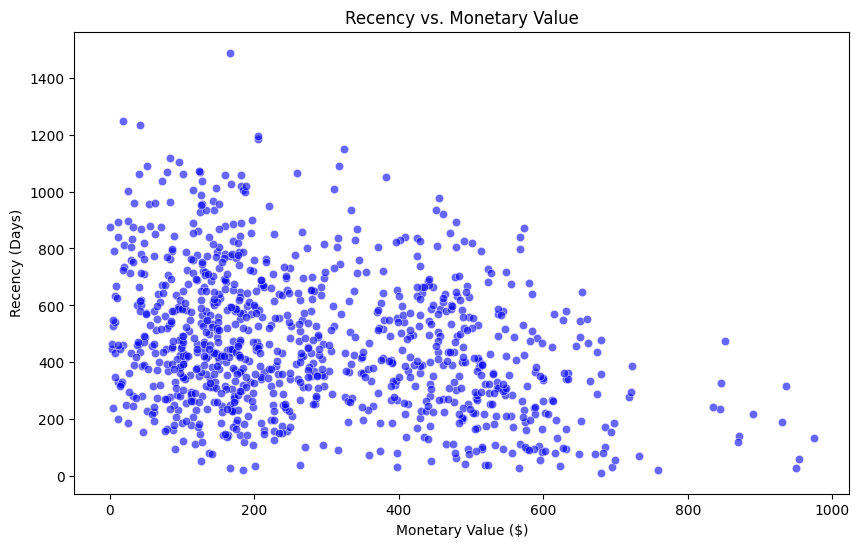

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=marge_rfm["Recency (Days)"], y=marge_rfm["Monetary ($)"], alpha=0.6, color="blue")

# Customize the plot
plt.ylabel("Recency (Days)")
plt.xlabel("Monetary Value ($)")
plt.title("Recency vs. Monetary Value")

# Show the plot
plt.show()


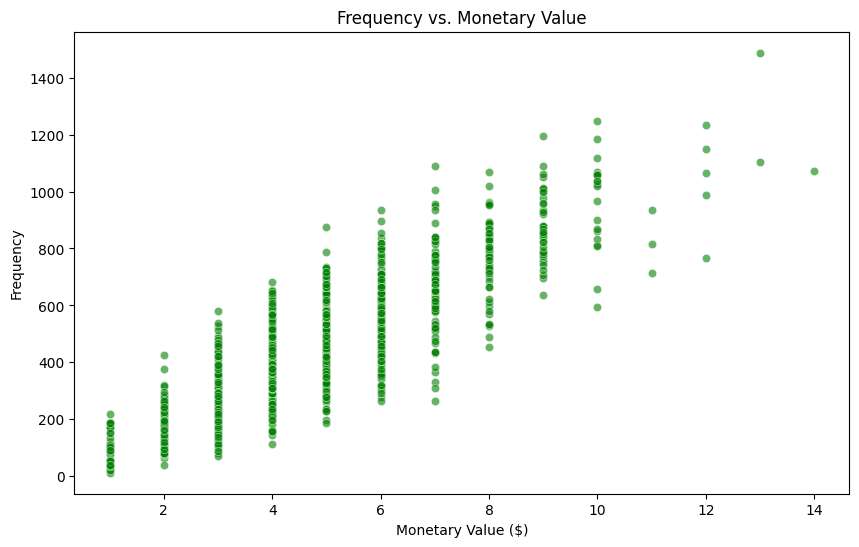

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=marge_rfm["Frequency"], y=marge_rfm["Monetary ($)"], alpha=0.6, color="green")

# Customize the plot
plt.ylabel("Frequency")
plt.xlabel("Monetary Value ($)")
plt.title("Frequency vs. Monetary Value")

# Show the plot
plt.show()

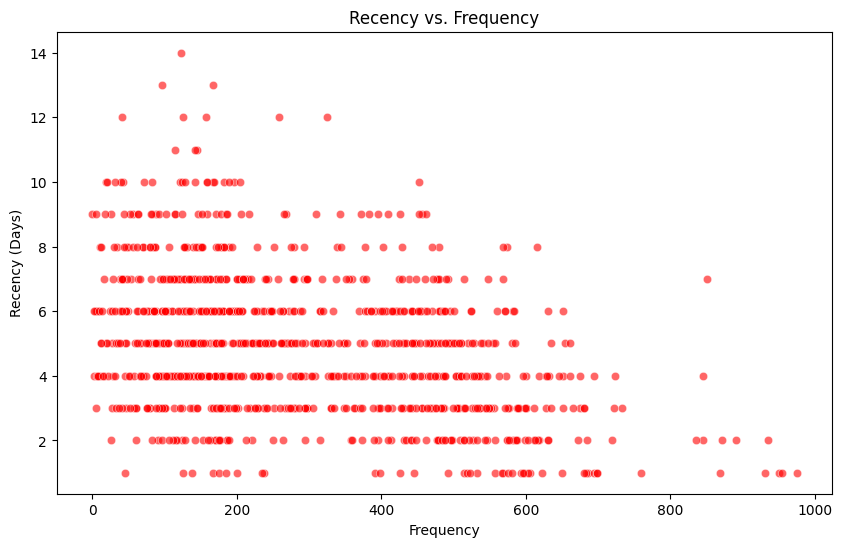

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=marge_rfm["Recency (Days)"], y=marge_rfm["Frequency"], alpha=0.6, color="red")

# Customize the plot
plt.ylabel("Recency (Days)")
plt.xlabel("Frequency")
plt.title("Recency vs. Frequency")

# Show the plot
plt.show()